In [59]:
import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [4]:
###query= """with initial_dataset as (
  select
    event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialView','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','AAPageA','ProPageA','GoldPageA','AAPageF','ProPageF','GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraphFromButton','PlayNextParagraphFromButton','in_app_purchase','PurchaseNormal')
),   
premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),
purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),
relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),
relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 7 day)
)
select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;""" ####
### df = pandas_gbq.read_gbq(query, project_id= 'beelinguapp') ####

In [81]:
query="""with initial_dataset as (
  select
    case 
      when event_name like 'sv__OnBoardingTutorialVi%' then 'sv__OnBoardingTutorialView'
      else event_name
    end as event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie',"in_app_purchase","PurchaseNormal")
),   
premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),
purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),
relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),
relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 7 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 7 day)
)
select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;"""
df2 = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

In [15]:
query="""with initial_dataset as (
  select
    case 
      when event_name like 'sv__OnBoardingTutorialVi%' then 'sv__OnBoardingTutorialView'
      else event_name
    end as event_name,
    optional_label,
    event_timestamp,
    event_date,
    user_id,
    user_pseudo_id,
    ga_session_id,
    user_history_event_number,
    session_event_number,
    platform,
    device_language,
    country
  from
    analytics_151430920.firebase_facts_events as eve
  where
    eve.event_timestamp >= '2020-11-01'
  and
    eve.event_name in ('sv__OnBoardingTutorialVi','sv__WelcomeCarouselDialog','sv__NewPremiumAct','TryToBuyNewPAct','TryToBuyNewPF','ClickOnWholeView','StartListening','sv__StoryDetails','StartNStory','StartBekids','FabClickedPremium','PremiumBarClickedSD','PremiumBarClickedMain','sv__AAPageA','sv__ProPageA','sv_GoldPageA','sv__AAPageF','sv__ProPageF','sv__GoldPageF','EnterFcMore','sv__GlossaryF','LibraryClicked','sv__Libraries','PlayPrevParagraph','PlayNextParagraphFromBut','sv__OnBoardingTutorialVie',"in_app_purchase","PurchaseNormal")
),   
premium_promo_shown as (
  select distinct
    user_pseudo_id,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_premium_promo_shown_timestamp
  from
    initial_dataset
  where
    event_name = 'sv__WelcomeCarouselDialog'
),
purchases as (
  select distinct
    'in_app_purchase' as event_name,
    first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_timestamp,
    first_value(event_date) over (partition by user_pseudo_id order by event_timestamp) as first_purchase_date,
    first_value(optional_label) over (partition by user_pseudo_id order by event_timestamp) as optional_label,
    last_value(user_id) over (partition by user_pseudo_id order by event_timestamp) as user_id,
    user_pseudo_id,
    first_value(ga_session_id) over (partition by user_pseudo_id order by event_timestamp) as ga_session_id,
    first_value(user_history_event_number) over (partition by user_pseudo_id order by event_timestamp) as user_history_event_number,
    first_value(session_event_number) over (partition by user_pseudo_id order by event_timestamp) as session_event_number,
    first_value(platform) over (partition by user_pseudo_id order by event_timestamp) as platform,
    first_value(device_language) over (partition by user_pseudo_id order by event_timestamp) as device_language,
    first_value(country) over (partition by user_pseudo_id order by event_timestamp) as country
  from
    initial_dataset
  where
    event_name in ('in_app_purchase','PurchaseNormal')
),
relevant_purchases as (
  select
    pu.event_name,
    pu.first_purchase_timestamp,
    pu.first_purchase_date,
    ps.first_premium_promo_shown_timestamp,
    pu.optional_label,
    pu.user_id,
    pu.user_pseudo_id,
    pu.ga_session_id,
    pu.user_history_event_number,
    pu.session_event_number,
    pu.platform,
    pu.device_language,
    pu.country
  from
    purchases as pu
  join
    premium_promo_shown as ps on ps.user_pseudo_id = pu.user_pseudo_id
  where
    pu.first_purchase_timestamp > timestamp_add(ps.first_premium_promo_shown_timestamp, interval 30 minute)
),
relevant_events as (
  select
    ini.event_name,
    ini.event_timestamp,
    ini.event_date,
    ini.optional_label,
    ini.user_id,
    ini.user_pseudo_id,
    ini.ga_session_id,
    ini.user_history_event_number,
    ini.session_event_number,
    ini.platform,
    ini.device_language,
    ini.country
  from
    initial_dataset as ini
  left join
    premium_promo_shown as ps on ps.user_pseudo_id = ini.user_pseudo_id
  where
    event_name != 'in_app_purchase'
  and
    ini.event_timestamp between ps.first_premium_promo_shown_timestamp and timestamp_add(first_premium_promo_shown_timestamp, interval 30 day)
  union all
  select
    rep.event_name,
    rep.first_purchase_timestamp as event_timestamp,
    rep.first_purchase_date as event_date,
    rep.optional_label,
    rep.user_id,
    rep.user_pseudo_id,
    rep.ga_session_id,
    rep.user_history_event_number,
    rep.session_event_number,
    rep.platform,
    rep.device_language,
    rep.country
  from
    relevant_purchases as rep
  where
    rep.first_purchase_timestamp between rep.first_premium_promo_shown_timestamp and timestamp_add(rep.first_premium_promo_shown_timestamp, interval 30 day)
)
select
  user_pseudo_id,
  event_name,
  count(event_timestamp) as occurrences_count,
  min(event_timestamp) as first_event_timestamp,
  max(event_timestamp) as last_event_timestamp
from
  relevant_events
group by 1,2;"""
df2 = pandas_gbq.read_gbq(query, project_id= 'beelinguapp')

In [4]:
df = pd.read_csv("second_query.csv",index_col=0)

In [5]:
df.head()

,user_pseudo_id,event_name,occurrences_count,first_event_timestamp,last_event_timestamp
0,c3e460b3894979065f0b41877b9988b9,sv__GoldPageF,1,2020-11-01 17:59:31.844002+00:00,2020-11-01 17:59:31.844002+00:00
1,3c33ac7d0736acc0141260a319a2b434,EnterFcMore,1,2020-11-28 18:55:12.668000+00:00,2020-11-28 18:55:12.668000+00:00
2,adaf7c7783fb0e5f8c2a8337bff3bad5,TryToBuyNewPF,1,2020-11-28 18:38:26.389028+00:00,2020-11-28 18:38:26.389028+00:00
3,d7e64b8a0cb91cd09cf7e95bbc1f91a5,EnterFcMore,1,2020-11-28 15:02:34.630001+00:00,2020-11-28 15:02:34.630001+00:00
4,9cb69e4f2aa7fd0c1890fae5ca183ef6,sv__GoldPageF,4,2020-11-28 09:37:16.538012+00:00,2020-11-28 09:45:30.916018+00:00


In [23]:
df2["first_event_timestamp"].max() - df2["first_event_timestamp"].min()

Timedelta('37 days 22:54:39.483026')

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397130 entries, 0 to 397129
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   user_pseudo_id         397130 non-null  object             
 1   event_name             397130 non-null  object             
 2   occurrences_count      397130 non-null  int64              
 3   first_event_timestamp  397130 non-null  datetime64[ns, UTC]
 4   last_event_timestamp   397130 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 12.1+ MB


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370486 entries, 0 to 370485
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_pseudo_id         370486 non-null  object
 1   event_name             370486 non-null  object
 2   occurrences_count      370486 non-null  int64 
 3   first_event_timestamp  370486 non-null  object
 4   last_event_timestamp   370486 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.3+ MB


In [19]:
len(df2)

397130

In [20]:
len(df)

370486

In [6]:
df.user_pseudo_id.nunique()

59628

In [7]:
df["event_name"].value_counts()

sv__WelcomeCarouselDialog     59628
sv__Libraries                 55143
sv__StoryDetails              45163
ClickOnWholeView              44735
StartListening                39521
StartNStory                   34345
LibraryClicked                18947
sv__NewPremiumAct             15360
sv__AAPageA                    8797
PremiumBarClickedMain          8566
sv__ProPageA                   6493
sv__AAPageF                    5739
sv__ProPageF                   4427
sv__GlossaryF                  4306
PremiumBarClickedSD            3745
StartBekids                    3707
PlayNextParagraphFromBut       3314
FabClickedPremium              2208
TryToBuyNewPAct                1859
sv__GoldPageF                  1772
EnterFcMore                    1614
TryToBuyNewPF                   663
sv__OnBoardingTutorialView      221
PlayPrevParagraph               155
in_app_purchase                  58
Name: event_name, dtype: int64

In [37]:
df2["event_name"].value_counts()

sv__WelcomeCarouselDialog     62818
sv__Libraries                 58893
sv__StoryDetails              48031
ClickOnWholeView              47479
StartListening                42070
StartNStory                   36663
LibraryClicked                20693
sv__NewPremiumAct             16721
sv__AAPageA                    9651
PremiumBarClickedMain          9360
sv__ProPageA                   7138
sv__AAPageF                    6340
sv__ProPageF                   4909
sv__GlossaryF                  4765
PremiumBarClickedSD            4225
StartBekids                    4205
PlayNextParagraphFromBut       3774
FabClickedPremium              2361
TryToBuyNewPAct                2036
sv__GoldPageF                  1994
EnterFcMore                    1760
TryToBuyNewPF                   716
sv__OnBoardingTutorialView      267
PlayPrevParagraph               169
in_app_purchase                  92
Name: event_name, dtype: int64

In [38]:
df_log = df2.pivot_table(index=["user_pseudo_id"],columns=["event_name"],fill_value=0)

In [39]:
df_log.head()

occurrences_count              \
event_name                        ClickOnWholeView EnterFcMore   
user_pseudo_id                                                   
0000892c8eff256f940b90c82d8c6d23                 0           0   
0000bf6a4004cd40d8f190bee72aa98e                 3           0   
0000d2213ba1e2c0d3d6221e8f092888                 1           0   
0002b6303b89915e39a76130ca7f2730                 0           0   
00039a05ee528224e4fb0c122e34828a                 2           0   

                                                                   \
event_name                       FabClickedPremium LibraryClicked   
user_pseudo_id                                                      
0000892c8eff256f940b90c82d8c6d23                 0              0   
0000bf6a4004cd40d8f190bee72aa98e                 0              0   
0000d2213ba1e2c0d3d6221e8f092888                 0              0   
0002b6303b89915e39a76130ca7f2730                 0              0   
00039a05ee528224e4fb0c122e34828a                 0              1   

                                                                             \
event_name                       PlayNextParagraphFromBut PlayPrevParagraph   
user_pseudo_id                                                                
0000892c8eff256f940b90c82d8c6d23                        0                 0   
0000bf6a4004cd40d8f190bee72aa98e                        5                 0   
0000d2213ba1e2c0d3d6221e8f092888                        0                 0   
0002b6303b89915e39a76130ca7f2730                        0                 0   
00039a05ee528224e4fb0c122e34828a                        0                 0   

                                                                            \
event_name                       PremiumBarClickedMain PremiumBarClickedSD   
user_pseudo_id                                                               
0000892c8eff256f940b90c82d8c6d23                     0                   0   
0000bf6a4004cd40d8f190bee72aa98e                     0                   0   
0000d2213ba1e2c0d3d6221e8f092888                     0                   0   
0002b6303b89915e39a76130ca7f2730                     0                   0   
00039a05ee528224e4fb0c122e34828a                     0                   0   

                                                             ...              \
event_name                       StartBekids StartListening  ... sv__AAPageF   
user_pseudo_id                                               ...               
0000892c8eff256f940b90c82d8c6d23           0              0  ...           0   
0000bf6a4004cd40d8f190bee72aa98e           1              3  ...           0   
0000d2213ba1e2c0d3d6221e8f092888           0              0  ...           0   
0002b6303b89915e39a76130ca7f2730           0              0  ...           0   
00039a05ee528224e4fb0c122e34828a           0              2  ...           0   

                                                                            \
event_name                       sv__GlossaryF sv__GoldPageF sv__Libraries   
user_pseudo_id                                                               
0000892c8eff256f940b90c82d8c6d23             0             0             1   
0000bf6a4004cd40d8f190bee72aa98e             0             0             3   
0000d2213ba1e2c0d3d6221e8f092888             0             0             2   
0002b6303b89915e39a76130ca7f2730             0             0             1   
00039a05ee528224e4fb0c122e34828a             0             0             4   

                                                                               \
event_name                       sv__NewPremiumAct sv__OnBoardingTutorialView   
user_pseudo_id                                                                  
0000892c8eff256f940b90c82d8c6d23                 0                          0   
0000bf6a4004cd40d8f190bee72aa98e                 0                          0   
0000d2213ba1e2c0d3d622

In [40]:
df_log.columns = df_log.columns.droplevel() #to get rid of the first column name of nested column

In [41]:
df_log.reset_index(inplace=True)

In [42]:
df_log

event_name,user_pseudo_id,ClickOnWholeView,EnterFcMore,FabClickedPremium,LibraryClicked,PlayNextParagraphFromBut,PlayPrevParagraph,PremiumBarClickedMain,PremiumBarClickedSD,StartBekids,...,sv__AAPageF,sv__GlossaryF,sv__GoldPageF,sv__Libraries,sv__NewPremiumAct,sv__OnBoardingTutorialView,sv__ProPageA,sv__ProPageF,sv__StoryDetails,sv__WelcomeCarouselDialog
0,0000892c8eff256f940b90c82d8c6d23,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0000bf6a4004cd40d8f190bee72aa98e,3,0,0,0,5,0,0,0,1,...,0,0,0,3,0,0,0,0,5,1
2,0000d2213ba1e2c0d3d6221e8f092888,1,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,1,2
3,0002b6303b89915e39a76130ca7f2730,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,00039a05ee528224e4fb0c122e34828a,2,0,0,1,0,0,0,0,0,...,0,0,0,4,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62813,fff97498b44a275980fbf0f5e321f15c,3,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,6,1
62814,fff9bfbe8362a9ed9f33ab68774a8182,2,0,0,4,0,0,0,0,0,...,0,1,0,16,0,0,0,0,3,1
62815,fff9fe0382fee2faa816b9a7a5637a2f,1,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,2,1
62816,fffaf70bc48332d839c49b3e83287a84,6,1,0,1,0,0,5,2,0,...,1,0,0,24,7,0,9,0,12,1


In [54]:
cols2 = [ 'ClickOnWholeView',
 'EnterFcMore',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'sv__GlossaryF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__StoryDetails',
]

In [51]:
len(cols)

24

In [62]:
cols

['ClickOnWholeView',
 'EnterFcMore',
 'FabClickedPremium',
 'LibraryClicked',
 'PlayNextParagraphFromBut',
 'PlayPrevParagraph',
 'PremiumBarClickedMain',
 'PremiumBarClickedSD',
 'StartBekids',
 'StartListening',
 'StartNStory',
 'TryToBuyNewPAct',
 'TryToBuyNewPF',
 'sv__AAPageA',
 'sv__AAPageF',
 'sv__GlossaryF',
 'sv__GoldPageF',
 'sv__Libraries',
 'sv__NewPremiumAct',
 'sv__OnBoardingTutorialView',
 'sv__ProPageA',
 'sv__ProPageF',
 'sv__StoryDetails',
 'sv__WelcomeCarouselDialog']

In [44]:
y = df_log['in_app_purchase']
X = df_log[cols]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.007219
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                62818
Model:                          Logit   Df Residuals:                    62793
Method:                           MLE   Df Model:                           24
Date:                Thu, 10 Dec 2020   Pseudo R-squ.:                  0.3450
Time:                        20:44:27   Log-Likelihood:                -453.46
converged:                       True   LL-Null:                       -692.34
Covariance Type:            nonrobust   LLR p-value:                 6.788e-86
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.4761      0.340    -21.979      0.000      -8.143      -6.809
ClickOnWholeView              -0.0898      0.026     -3.488      0.000      -0.140      -0.039
EnterFcMore                    0.3163      0.182      1.736      0.083      -0.041       0.673
FabClickedPremium              0.7860      0.263      2.988      0.003       0.270       1.302
LibraryClicked                 0.0998      0.022      4.571      0.000       0.057       0.143
PlayNextParagraphFromBut       0.0230      0.006      3.557      0.000       0.010       0.036
PlayPrevParagraph             -0.0384      0.326     -0.118      0.906      -0.678       0.601
PremiumBarClickedMain          0.5028      0.139      3.606      0.000       0.230       0.776
PremiumBarClickedSD            0.8644      0.196      4.403      0.000       0.480       1.249
StartBekids                   -0.1360      0.058     -2.347      0.019      -0.249      -0.022
StartListening                 0.0990      0.040      2.454      0.014       0.020       0.178
StartNStory                   -0.0528      0.027     -1.970      0.049      -0.105      -0.000
TryToBuyNewPAct                0.5052      0.098      5.135      0.000       0.312       0.698
TryToBuyNewPF                  0.0702      0.032      2.215      0.027       0.008       0.132
sv__AAPageA                    0.0374      0.085      0.441      0.660      -0.129       0.204
sv__AAPageF                    0.1736      0.201      0.865      0.387      -0.220       0.567
sv__GlossaryF                 -0.3516      0.093     -3.792      0.000      -0.533      -0.170
sv__GoldPageF                 -0.0799      0.252     -0.317      0.751      -0.574       0.414
sv__Libraries                  0.0042      0.002      2.401      0.016       0.001       0.008
sv__NewPremiumAct             -0.5695      0.129     -4.405      0.000      -0.823      -0.316
sv__OnBoardingTutorialView    -0.1015      0.240     -0.422      0.673      -0.573       0.370
sv__ProPageA                   0.0770      0.099      0.777      0.437      -0.117       0.271
sv__ProPageF                   0.1628      0.135      1.202      0.229      -0.103       0.428
sv__StoryDetails               0.0486      0.020      2.430      0.015       0.009       0.088
sv__WelcomeCarouselDialog     -0.0606      0.289     -0.210      0.834      -0.627       0.506
==============================================================================================
"""

<AxesSubplot:xlabel='occurrences_count', ylabel='Density'>

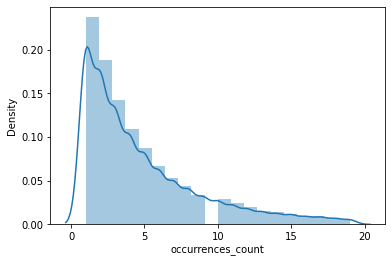

In [46]:
sns.distplot(df2[(df2.event_name=="sv__Libraries") & (df2.occurrences_count < 20)]["occurrences_count"],bins=20)
#occurences below 20

<AxesSubplot:xlabel='occurrences_count', ylabel='Density'>

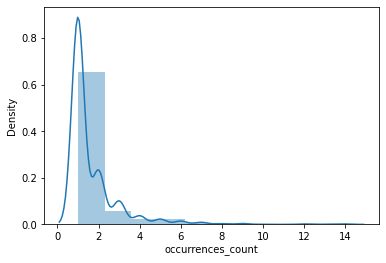

In [49]:
sns.distplot(df2[(df2.event_name=="TryToBuyNewPAct") & (df2.occurrences_count < 20)]["occurrences_count"],bins=10)

In [32]:
r = np.zeros_like(model.params)
r[1] = 1
r[18] = -1
T_test = model.t_test(r)
print(T_test)

#hypothesis test, average of 2 things are equal, coeffiecients are also average
#pair-wise

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1965      0.050     -3.956      0.000      -0.294      -0.099


In [55]:
y = df_log['in_app_purchase']
X = df_log[cols2]
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.008248
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        in_app_purchase   No. Observations:                62818
Model:                          Logit   Df Residuals:                    62804
Method:                           MLE   Df Model:                           13
Date:                Thu, 10 Dec 2020   Pseudo R-squ.:                  0.2516
Time:                        20:56:28   Log-Likelihood:                -518.14
converged:                       True   LL-Null:                       -692.34
Covariance Type:            nonrobust   LLR p-value:                 1.671e-66
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -7.2331      0.141    -51.419      0.000      -7.509      -6.957
ClickOnWholeView              -0.0988      0.022     -4.394      0.000      -0.143      -0.055
EnterFcMore                    0.4011      0.204      1.967      0.049       0.001       0.801
LibraryClicked                 0.1494      0.027      5.625      0.000       0.097       0.201
PlayNextParagraphFromBut       0.0276      0.006      4.641      0.000       0.016       0.039
PlayPrevParagraph             -0.0110      0.328     -0.034      0.973      -0.653       0.631
StartBekids                   -0.1359      0.046     -2.944      0.003      -0.226      -0.045
StartListening                 0.1246      0.030      4.206      0.000       0.067       0.183
StartNStory                   -0.0689      0.021     -3.219      0.001      -0.111      -0.027
sv__GlossaryF                 -0.3870      0.098     -3.952      0.000      -0.579      -0.195
sv__Libraries                  0.0048      0.002      3.066      0.002       0.002       0.008
sv__NewPremiumAct              0.0255      0.009      2.809      0.005       0.008       0.043
sv__OnBoardingTutorialView    -0.0870      0.205     -0.425      0.671      -0.488       0.314
sv__StoryDetails               0.0427      0.016      2.711      0.007       0.012       0.074
==============================================================================================
"""

<AxesSubplot:xlabel='event_name', ylabel='event_name'>

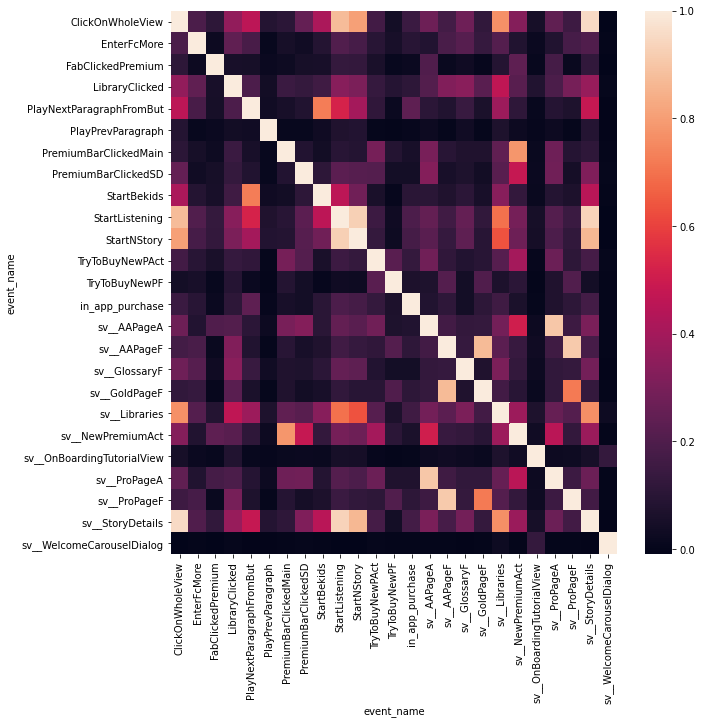

In [61]:
plt.figure(figsize=(10,10))
sns.heatmap(df_log.corr())

In [30]:
r

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.])